In [1]:
from osgeo import gdal
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
import numpy as np
import re
import os
import random
%matplotlib inline
# %matplotlib notebook


def load_data(infile, band=1):
    ds = gdal.Open(infile, gdal.GA_ReadOnly)
    # Data array
    data = ds.GetRasterBand(band).ReadAsArray()
    # Map extent
    trans = ds.GetGeoTransform()
    xsize = ds.RasterXSize
    ysize = ds.RasterYSize
    extent = [trans[0], trans[0] + xsize * trans[1],
              trans[3] + ysize*trans[5], trans[3]]
    ds = None
    return data, extent


def plot_data(data, extent, cmap, title, barlabel):
    fig, ax = plt.subplots()
    im = ax.imshow(data, extent=extent, cmap=cmap)
    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_xlabel(barlabel, rotation=0, va="top")
    ax.set_title(title)
    fig.show()
    


def get_date(disp_names):
    date = []
    for n in disp_names:
        date.append(re.findall(r'\d{8}', n)[0])
    return date


def get_cum_disp(path):
    # get disp_geo file name
    disp_names = sorted([i for i in os.listdir(path) if i.endswith('disp_geo')])
    # get extent
    disp, extent = load_data(os.path.join(path, disp_names[1]))
    # generate lon,lat
    lon = np.linspace(extent[0], extent[1], disp.shape[1])
    lat = np.linspace(extent[3], extent[2], disp.shape[0])
    lons, lats = np.meshgrid(lon, lat)

    not_nan = (~np.isnan(disp))
    # reshape array
    lons = lons[not_nan].reshape((-1, 1))
    lats = lats[not_nan].reshape((-1, 1))
    # generate point ID
    num = np.arange(0, lons.shape[0]).reshape((-1, 1))
    # get 4 colums data (num lon lat disp)
    cum_disp = np.concatenate([num, lons, lats], axis=1)
    for disp_name in disp_names:
        disp_path = os.path.join(path, disp_name)
        disp, _ = load_data(disp_path)
        disp = disp[not_nan].reshape((-1, 1))
        cum_disp = np.concatenate([cum_disp, disp], axis=1)
    return disp_names, extent, cum_disp, num, lons, lats


def random_downsample(data, percent):
    point_num = data.shape[0]
    index = random.sample(range(point_num), int(point_num * percent))
    return data[index, :]


def plot_points_disp_in_one(cum_disp, date, num_list, y_lim, figsize=(10,5) ,flag=False, aspect=0.2):
    cum_disp = np.asarray(cum_disp, dtype=np.float32)
    points_disp = []

    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlabel('date', fontsize=20)
    ax.set_ylabel('cumulative displacement (mm)', fontsize=20)
    ax.set_title('Point displacement', fontsize=25)
    ax.set_ylim(y_lim[0], y_lim[1])
    ax.set_aspect(aspect)
    y_major_locator=MultipleLocator(10)
    ax.yaxis.set_major_locator(y_major_locator)
    # ax.minorticks_on()
    ax.xaxis.grid(True, which='major')
    ax.xaxis.set_tick_params(rotation=30, labelsize=10)
    ax.yaxis.grid(True, which='major')
    ax.yaxis.set_tick_params(rotation=0, labelsize=10)
    ax.set_xmargin(0.02)
    for num in num_list:
        if num >= cum_disp.shape[0] or num < 0:
            print(f"Error: cannot find point {num}.")
        else:
            line = cum_disp[num, :]
            points_disp.append(list(line))
            ax.plot(date, line[3:], label=str(num), marker='o')
            ax.xaxis.set_ticks(date[::2])
    ax.legend(loc='upper right', fontsize=15, ncol=2)
    fig.show()
    # save fig
    if flag:
        fig.savefig('cum_disp.png', dpi=600)
    # for i in point_disp:
    #     print('{}\n'.format(i))

## 读取累计形变数据并绘图

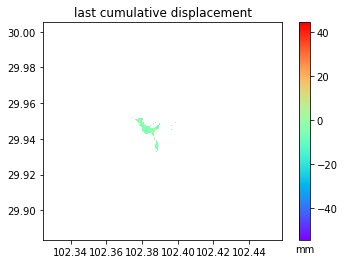

In [2]:
path = r'C:\thorly\Files\landslide\9_SBAS_processing\inversion\geocoded'

disp_names, extent, cum_disp, num, lons, lats = get_cum_disp(path)
# os.chdir(path)
# np.savetxt('cumulative_disp.txt', cum_disp, fmt='%4f')
# get last cumulative displacement
last_cum_disp, extent = load_data(os.path.join(path, disp_names[-1]))
plot_data(data=last_cum_disp, extent=extent, cmap='rainbow', title='last cumulative displacement', barlabel='mm')

## 平均速率图随机降采样

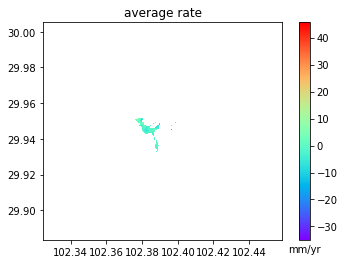

In [3]:
average_rate, extent = load_data(os.path.join(path, "SI_vel_geo"))

plot_data(data=average_rate, extent=extent, cmap='rainbow', title='average rate', barlabel='mm/yr')

not_nan = (~np.isnan(average_rate))
average_rate = average_rate[not_nan].reshape((-1, 1))

save_data = np.hstack((num, lons, lats, average_rate))
# downsample
downsample_data = random_downsample(save_data, 0.7)
# save average velocity rate
os.chdir(os.path.dirname(os.path.dirname(path)))
np.savetxt('average_rate_sample9.txt', downsample_data, fmt='%4f')

## 绘制累计形变趋势图

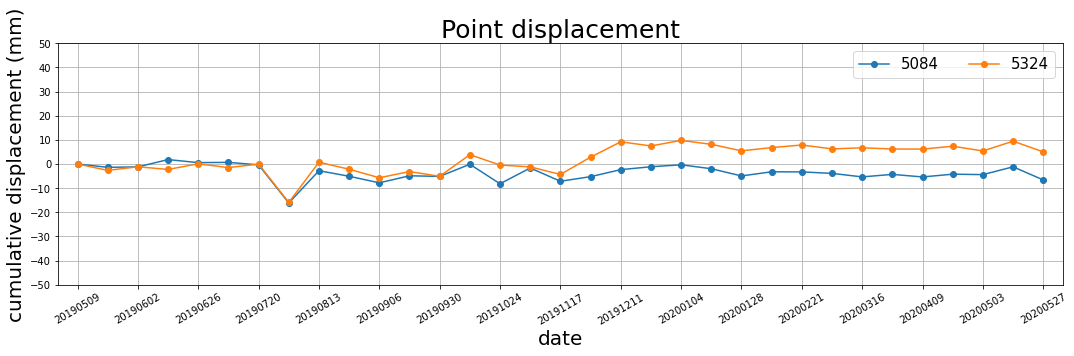

In [4]:
# path = r'C:\thorly\Files\landslide\9_SBAS_processing\inversion\geocoded'
# disp_names, extent, cum_disp, num, lons, lats = get_cum_disp(path)
# last_cum_disp, extent = load_data(os.path.join(path, disp_names[-1]))

date = get_date(disp_names)
# num_list = sorted([4348, 4466, 4465, 3789, 5154, 4781, 3687])
# num_list = sorted([3484, 3562])
num_list = sorted([5324, 5084])
# num_list = sorted([5204, 5142, 5143, 5310, 4781])
plot_points_disp_in_one(cum_disp, date, num_list, [-50, 50], figsize=(18,9), flag=False, aspect=0.08)

